In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist
from rsc_functions.utility.rank_genes_groups import return_markers,rank_genes_groups
from rsc_functions.reports.plot import plot_expression

In [2]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 

In [3]:
path_xenium = os.path.join(path,"cell_feature_matrix.h5")
path_cells = os.path.join(path,"cells.zarr.zip")
adata = sc.read_10x_h5(path_xenium)
rsc.get.anndata_to_GPU(adata)
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="mt-")
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT"])
def open_zarr(path: str) -> zarr.Group:
    store = (zarr.ZipStore(path, mode="r") if path.endswith(".zip") else zarr.DirectoryStore(path))
    return zarr.group(store=store)
root = open_zarr(path_cells)
column_names = dict(root['cell_summary'].attrs.items())['column_names']
def build_obs(andata,root,column_names):
    for i in range(len(column_names)):
        andata.obs[str(column_names[i])] = np.array(root["cell_summary"])[:,i]
    spatial = andata.obs[["cell_centroid_x", "cell_centroid_y"]]
    adata.obsm["spatial"] = spatial.values
    return andata
andata = build_obs(adata,root,column_names)
andata.var_names_make_unique()
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="mt-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])

In [4]:
rsc.pp.filter_cells(andata, min_count=10,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=5)
rsc.pp.filter_genes(andata, max_count=200_000)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=1500, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

filtered out 3685 cells
filtered out 1 genes based on n_cells_by_counts
filtered out 53 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [18]:
fig, ax = plt.subplots(4, 1, figsize=(15, 60))
with PdfPages(os.path.join(pathout, f'Report_fetures_spaitial_map.pdf')) as pdf:
    plt.rcParams['figure.dpi'] = 600
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax[0], set_xlabel_cbar = 'Total Count',size = 0.1,alpha = 1)
    plot_spatial_data(andata, 'cell_area', fig = fig, ax = ax[1],set_xlabel_cbar = 'Cell Area',size = 0.1,alpha = 1)
    plot_spatial_data(andata, 'nucleus_area', fig = fig , ax = ax[2],set_xlabel_cbar = 'Nucleus Area',size = 0.1,alpha = 1)
    plot_spatial_data(andata, 'nucleus_count', fig = fig , ax = ax[3],set_xlabel_cbar = 'Nucleus Count',size = 0.1,alpha = 1)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [5]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=25)
rsc.tl.leiden(andata, random_state=1337, resolution=0.5, key_added='cluster') 

In [11]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(os.path.join(pathout, f'Report_spatial_map_plot.pdf')) as pdf:
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    plt.rcParams['figure.dpi'] = 800
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    clusterColorMap = plot_spatial(andata,ax = ax, features = None, title = '',markerscale = 30, xlab = '',ylab ='',size = 0.1,random_palette = True)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [21]:
rsc.get.anndata_to_CPU(andata)
sc.tl.rank_genes_groups(andata, groupby="cluster", method="wilcoxon")

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_sing

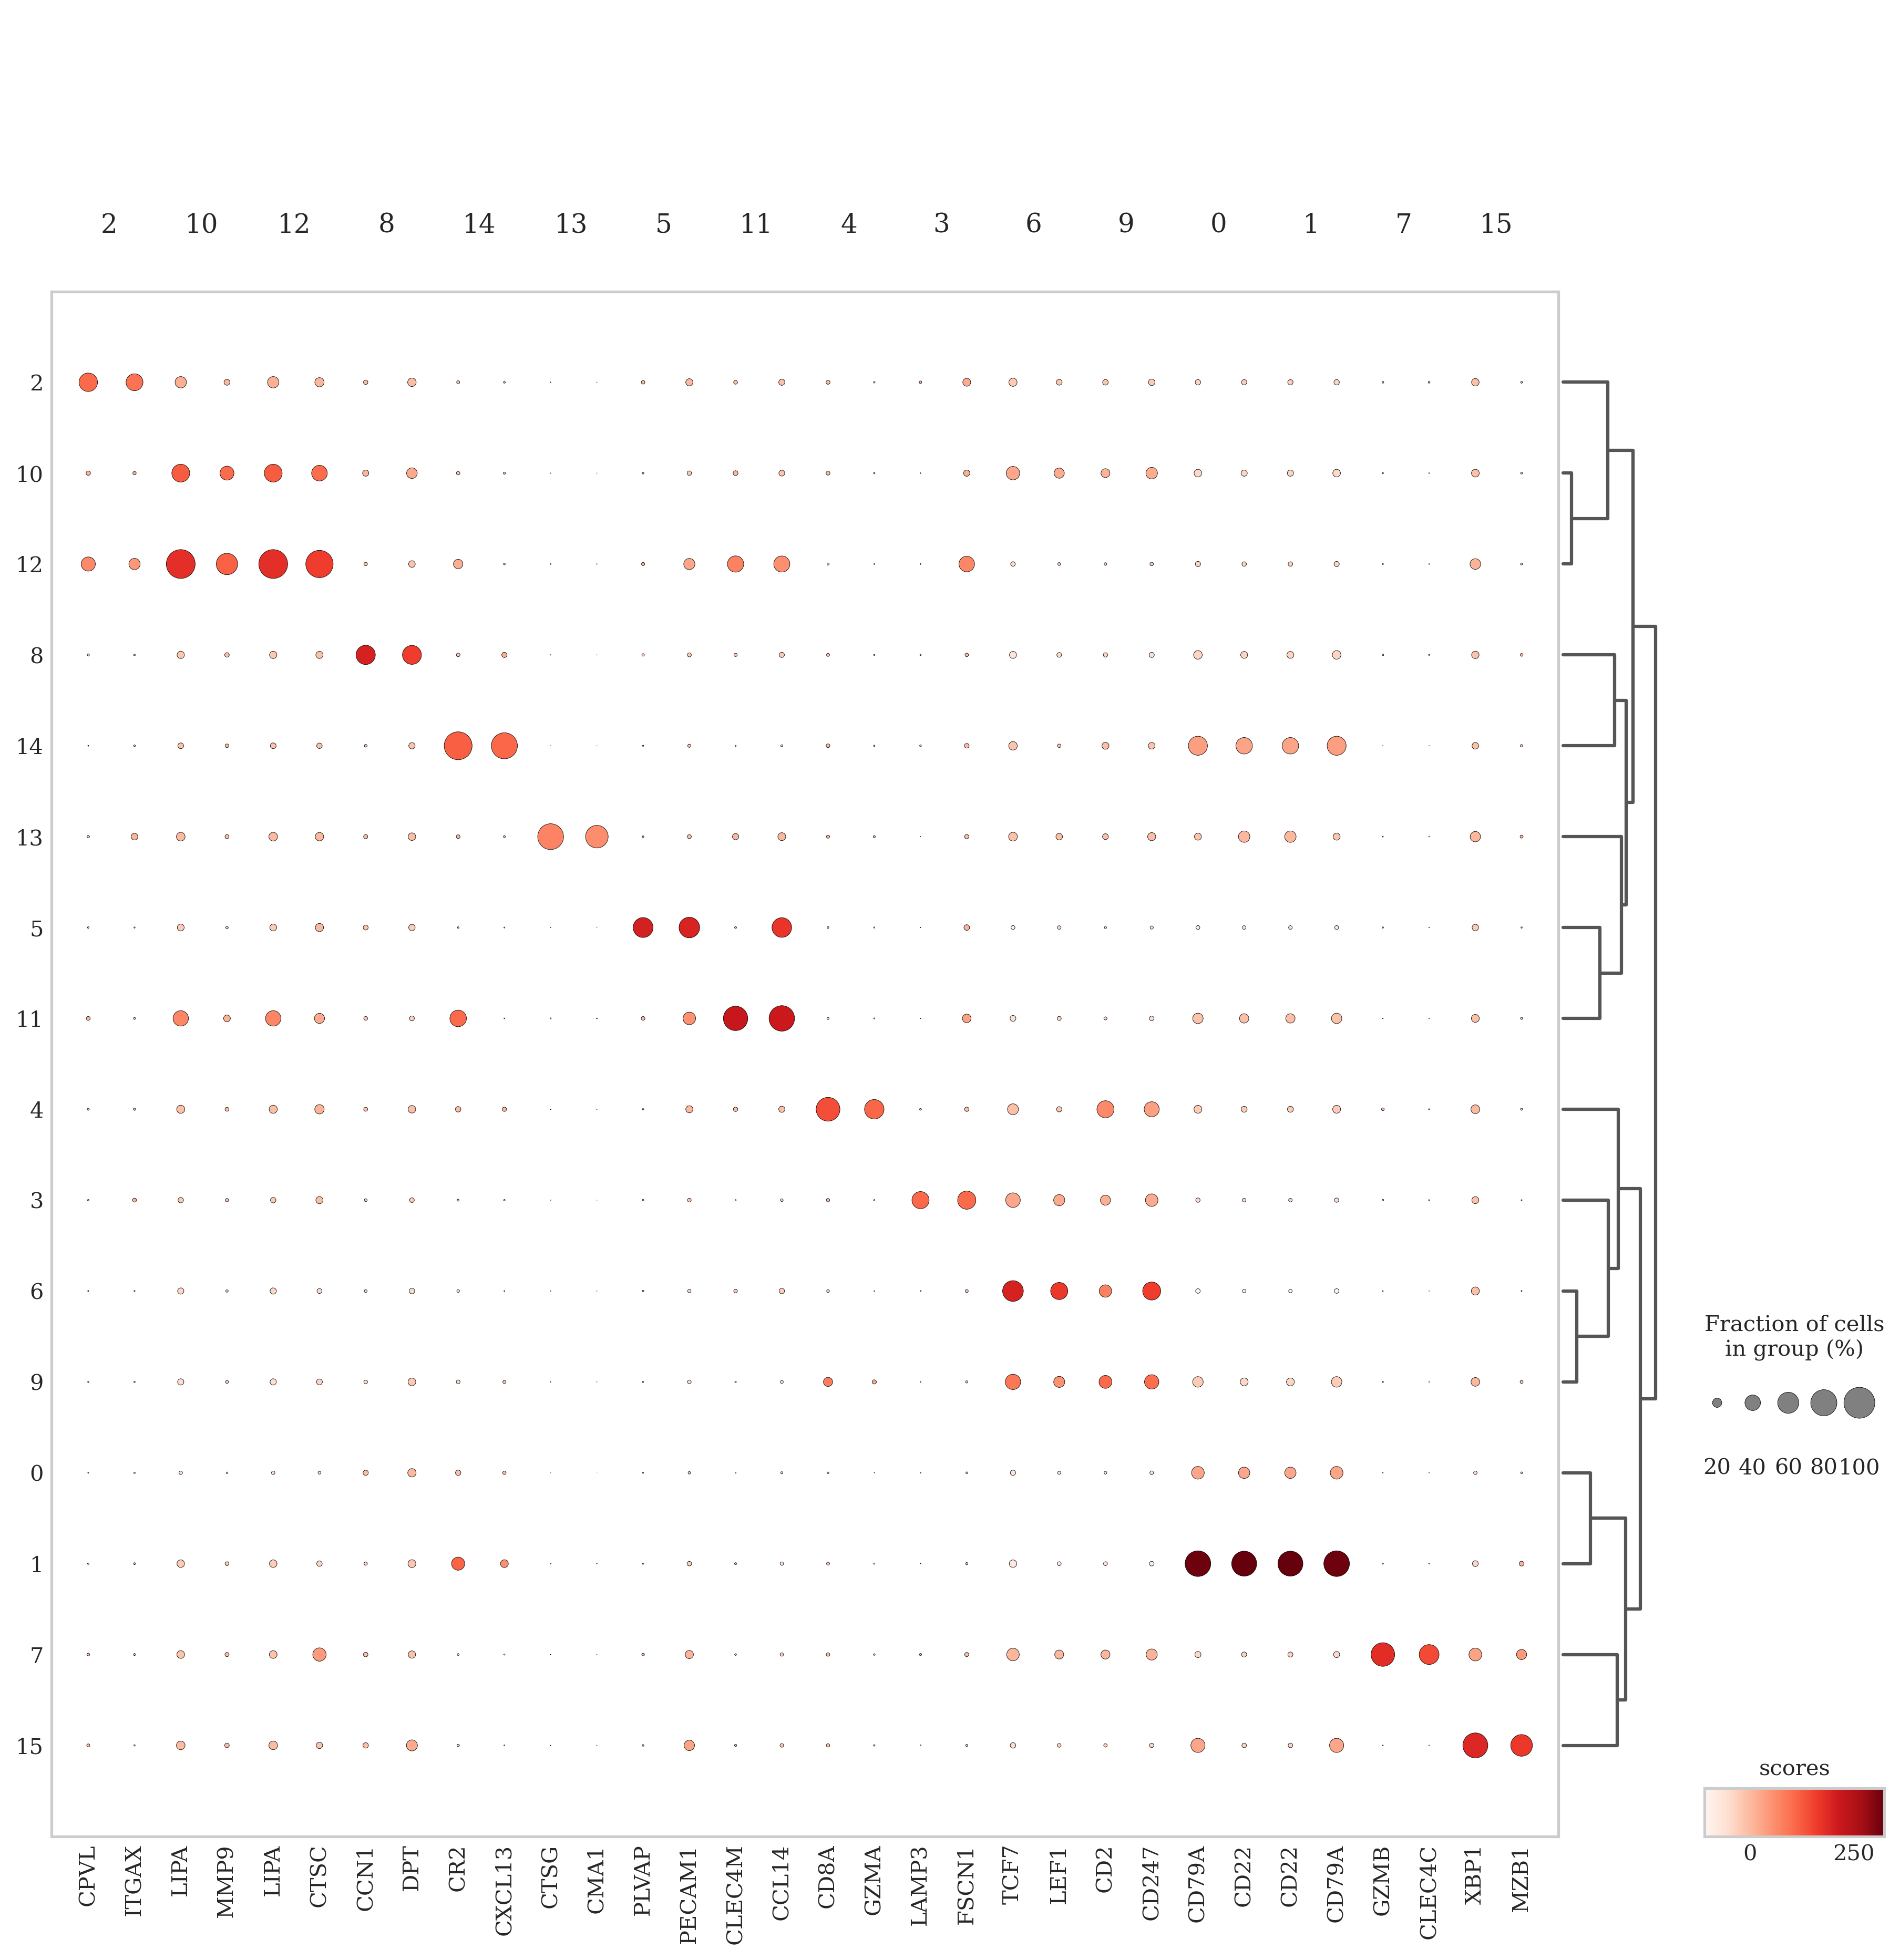

In [41]:
with PdfPages(os.path.join(pathout, f'dendrogram.pdf')) as pdf:
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    sc.pl.rank_genes_groups_dotplot(andata, groupby="cluster",n_genes=2,values_to_plot = 'scores',ax =ax)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()

In [28]:
andata.uns['clusterColorMap'] = clusterColorMap

In [42]:
import squidpy as sq
sq.gr.spatial_neighbors(andata, coord_type="generic",delaunay = True)
sq.gr.nhood_enrichment(andata, cluster_key="cluster")

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.79/s]


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


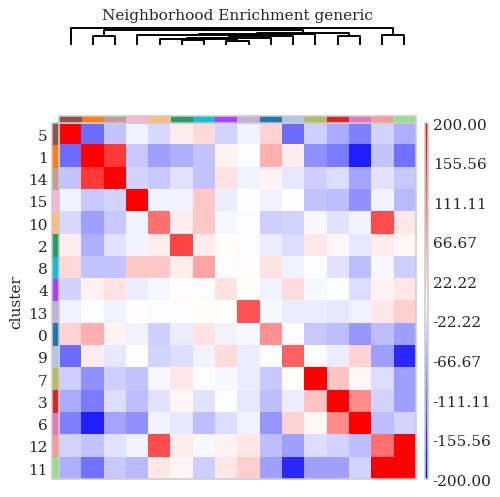

In [43]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
n_bins = 100  # Discretize into 100 bins
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sq.pl.nhood_enrichment(
    andata,
    title = "Neighborhood Enrichment generic",
    cluster_key="cluster",
    method="average",
    cmap=custom_cmap,
    vmin=-200,
    vmax=200,
    figsize=(5, 5),
)

<center>Save Matrices - knn Distance and Connectivities

In [44]:
import cupy as cp
from cupyx.scipy.sparse import csr_matrix 

In [45]:
def save_matrix(matrix,pathout,file_name = "obsp_distances_large.npz"):
    cp.savez(os.path.join(pathout, file_name),  
            data=matrix.data,  
            indices=matrix.indices,  
            indptr=matrix.indptr,  
            shape=matrix.shape) 

In [46]:
sparse_matrix = andata.obsp['distances']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_distances_large.npz")
sparse_matrix = andata.obsp['connectivities']
save_matrix(matrix = sparse_matrix,pathout = pathout,file_name = "obsp_connectivities_large.npz")

In [47]:
andata

AnnData object with n_obs × n_vars = 705298 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'cluster_colors', 'rank_genes_groups', 'dendrogram_cluster', 'clusterColorMap', 'spatial_neighbors', 'cluster_nhood_enrichment'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

In [52]:
import pickle
with open(os.path.join(pathout,"andata_uns_mtracies.pkl"), 'wb') as buff:
     pickle.dump({'config':andata.uns['config'],'cluster_colors':andata.uns['cluster_colors'], 'rank_genes_groups':andata.uns['rank_genes_groups'], 'clusterColorMap':andata.uns['clusterColorMap']}, buff)

In [56]:
import pickle
with open(os.path.join(pathout,"andata_obsm_mtracies.pkl"), 'wb') as buff:
     pickle.dump({'spatial':andata.obsm['spatial'],'X_pca':andata.obsm['X_pca']}, buff)

In [58]:
andata_save = andata.copy()
# andata_save.X = andata_save.layers['log']
del andata_save.uns
# del andata_save.obsm
del andata_save.varm
# del andata_save.layers
del andata_save.obsp
andata_save.write_h5ad(os.path.join(pathout, "andata_save.h5ad"))

<center><h4> cupy load andta stlearn</center>
<sh>mamba activate stlearn-env</sh>

In [34]:
import cupy as cp
import cupyx
import scanpy as sc
import stlearn as st
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd

In [41]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 
andata = sc.read_h5ad(os.path.join(pathout, "andata_save.h5ad"))

In [42]:
andata

AnnData object with n_obs × n_vars = 705298 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'log'

In [49]:
def load_matrix(andata,pathout,npz_file = "obsp_distances.npz",mode = 'sparse', mat_name = 'distances'):
    npzfile = cp.load(os.path.join(pathout, npz_file))
    data = cp.array(npzfile['data'])
    indices = cp.array(npzfile['indices'])
    indptr = cp.array(npzfile['indptr'])
    shape = tuple(npzfile['shape'])
    
    # Reconstruct the sparse matrix
    sparse_matrix_distances = csr_matrix((data, indices, indptr), shape=shape)
    if mode== 'sparse':
        andata.obsp[mat_name] = sparse_matrix_distances
    else:
        andata.obsp[mat_name] = sparse_matrix_distances.get()
    return andata

In [50]:
andata = load_matrix(andata,pathout,npz_file = "obsp_connectivities_large.npz",mode = 'sparse', mat_name = 'distances')
andata = load_matrix(andata,pathout,npz_file = "obsp_distances_large.npz",mode = 'sparse', mat_name = 'connectivities')

In [51]:
andata.obs["imagerow"] = andata.obs["cell_centroid_x"]
andata.obs["imagecol"] = andata.obs["cell_centroid_y"]
andata.uns["spatial"] = andata.obsm["spatial"]
def make_uns_spatial(adata):
    max_size = np.max([adata.obs["imagerow"].max(), adata.obs["imagecol"].max()])
    max_size = int(max_size + 0.1 * max_size)
    image = Image.new("RGBA", (max_size, max_size), (255, 255, 255, 255))
    imgarr = np.array(image)
    adata.uns["spatial"] = {}
    adata.uns["spatial"]["id1"] = {}
    adata.uns["spatial"]["id1"]["images"] = {}
    adata.uns["spatial"]["id1"]["images"]["lowres"] = imgarr
    adata.uns["spatial"]["id1"]["use_quality"] = "lowres"
    adata.uns["spatial"]["id1"]["scalefactors"] = {}
    adata.uns["spatial"]["id1"]["scalefactors"]["tissue_low_scalef" ] = 1
    adata.uns["spatial"]["id1"]["scalefactors"]["spot_diameter_fullres"] = 15
    adata.uns["spatial"]["id1"]["scalefactors"][
            "tissue_" + "lowres" + "_scalef"
        ] = 1
    return adata
andata = make_uns_spatial(andata)

In [52]:
import os
import pickle

file_path = os.path.join(pathout, "andata_uns_mtracies.pkl")

if os.path.getsize(file_path) > 0:
    with open(file_path, 'rb') as buff:
        andata_uns_mtracies = pickle.load(buff)
else:
    print("File is empty. Cannot load data.")
    andata_uns_mtracies = None

In [53]:
andata_uns_mtracies.keys()

dict_keys(['config', 'cluster_colors', 'rank_genes_groups', 'clusterColorMap'])

In [54]:
andata.uns['cluster_colors'] = andata_uns_mtracies['cluster_colors']
andata.uns['clusterColorMap'] = andata_uns_mtracies['clusterColorMap']

In [8]:
### Calculating the number of grid spots we will generate
n_ = 250
print(f'{n_} by {n_} has this many spots:\n', n_*n_)

250 by 250 has this many spots:
 62500


In [9]:
### Gridding.
grid = st.tl.cci.grid(andata, n_row=n_, n_col=n_, use_label = 'cluster')
print( grid.shape ) # Slightly less than the above calculation, since we filter out spots with 0 cells.

Gridding...
(35389, 1500)


In [55]:
# sort colors by cluster from zero to 15
andata.uns['clusterColorMap'].index = andata.uns['clusterColorMap']['clusters']

In [56]:
# creat a cluster list 
clusterColorMap = andata.uns['clusterColorMap'].sort_index()['colors'].to_list()

In [59]:
df = pd.DataFrame({'cluster':grid.obs['cluster'],'x':grid.obsm['spatial'][:,1],'y':grid.obsm['spatial'][:,0]}).reset_index()

# colors saved from rsc analysis step
palette = andata.uns['clusterColorMap'].sort_index()['colors'].to_list()
# palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("tab20c")
# random.shuffle(palette)
# num_classes = len(df_andata['cluster'].unique())
# extended_palette = palette * (num_classes // len(palette) + 1)
# extended_palette = extended_palette[:num_classes]
# listed_cmap = ListedColormap(extended_palette)

clusters = sorted(np.unique(df['cluster'].values), key=int)
with PdfPages(os.path.join(pathout, f'Report_spatial_map_plot_grid_1.pdf')) as pdf:
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.dpi'] = 800
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    fig, axes = plt.subplots(1, 1, figsize=(15, 15))
    for i, cluster in enumerate(clusters):
        cluster_grid = df[df['cluster'] == cluster]
        axes.scatter(x=cluster_grid['x'], y=cluster_grid['y'], color=palette[i], label=f'{cluster}', s=3, alpha=1)
    axes.set_xticks([])
    axes.set_yticks([])
    axes.set_xlabel('')
    axes.set_ylabel('')
    axes.set_title(f'Grid cluster dominant spots')
    legend1 = axes.legend( title="Cluster",
                            bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
                            loc='upper left',
                            fontsize='small',  # Control the font size
                            title_fontsize='medium',
                            markerscale=5,  # Increase the size of the legend markers
                            frameon=False# Control the title font size
                            )
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
    pdf.savefig()
    plt.close()
    